# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers

import warnings
warnings.filterwarnings('ignore')

C:\Users\Rocky\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Rocky\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Reading the Dataset

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 6

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "Fruits dataset",
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE
        )

Found 1655 files belonging to 6 classes.


# Images & Labels

In [4]:
labels = dataset.class_names

print("Label Mappings for classes present in the training and validation datasets\n")
for label in labels:
    print('-',label)

Label Mappings for classes present in the training and validation datasets

- fresh_peaches_done
- fresh_pomegranates_done
- fresh_strawberries_done
- rotten_peaches_done
- rotten_pomegranates_done
- rotten_strawberries_done


In [5]:
len(dataset)

26

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

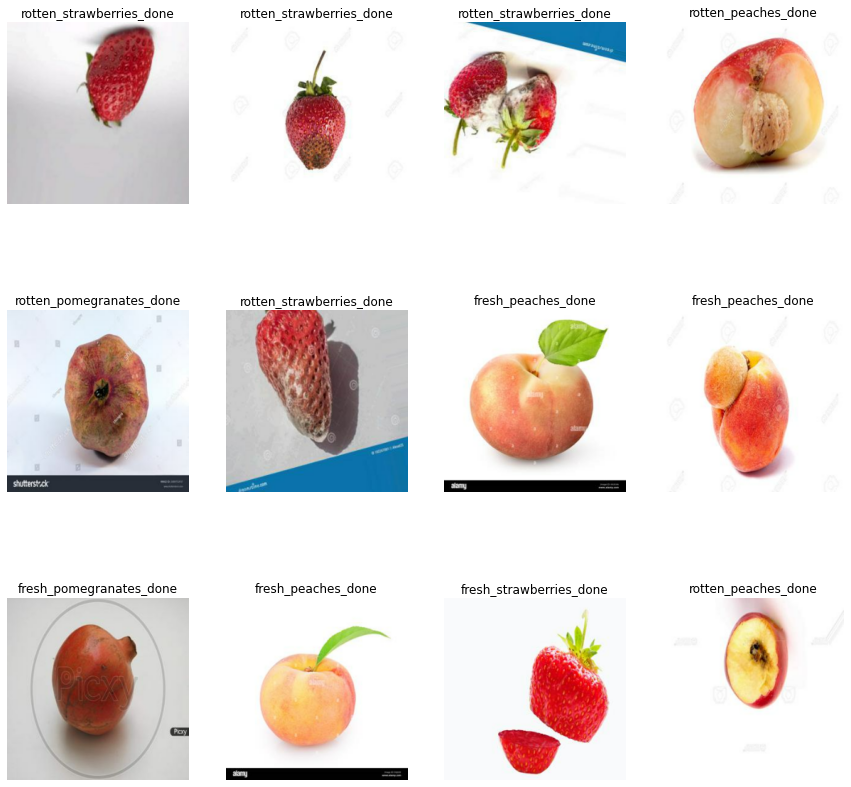

In [6]:
plt.figure(figsize=(15,15))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(labels[label_batch[i]])

# Applying Train-Test Split

In [7]:
len(dataset)

26

In [8]:
train_size = 0.8
len(dataset) * train_size

20.8

In [9]:
train_dataset = dataset.take(20)
len(train_dataset)

20

In [10]:
test_dataset = dataset.skip(20)
len(test_dataset)

6

In [11]:
val_size = 0.1
len(dataset) * val_size

2.6

In [12]:
val_dataset = test_dataset.take(3)
len(val_dataset)

3

In [13]:
test_dataset = test_dataset.skip(3)
len(test_dataset)

3

In [14]:
def get_dataset_train_test_split(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
      
    return train_ds, test_ds, val_ds

In [15]:
get_dataset_train_test_split(dataset)

(<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [16]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resizing_and_rescaling = tf.keras.Sequential([
                                layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                layers.experimental.preprocessing.Rescaling(1.0 / 255)
                        ])

In [18]:
data_augmentation = tf.keras.Sequential([
                                layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                layers.experimental.preprocessing.RandomHeight(0.2)
                    ])

# Building the Model

In [19]:
from tensorflow.keras.regularizers import l2

input_shape = (256, 256, 3)
n_classes = 6

model = models.Sequential([
    layers.Conv2D(16, (3,3), padding='valid', activation='relu', kernel_regularizer=l2(0.00005), input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (3,3), padding='valid', activation='relu', kernel_regularizer=l2(0.00005), input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3,3), padding='valid', activation='relu', kernel_regularizer=l2(0.00005), input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(128, (3,3), padding='valid', activation='relu', kernel_regularizer=l2(0.00005), input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(256, (3,3), padding='valid', activation='relu', kernel_regularizer=l2(0.00005), input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                      

In [21]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
EPOCHS = 10

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_dataset
)

Epoch 1/10
20/20 [==============================] - 66s 3s/step - loss: 0.0351 - accuracy: 0.9969 - val_loss: 1.3247 - val_accuracy: 0.7865
Epoch 2/10
20/20 [==============================] - 66s 3s/step - loss: 0.0319 - accuracy: 0.9977 - val_loss: 1.6449 - val_accuracy: 0.7656
Epoch 3/10
20/20 [==============================] - 67s 3s/step - loss: 0.0283 - accuracy: 0.9984 - val_loss: 2.3536 - val_accuracy: 0.7500
Epoch 4/10
20/20 [==============================] - 65s 3s/step - loss: 0.0263 - accuracy: 0.9969 - val_loss: 0.7589 - val_accuracy: 0.8646
Epoch 5/10
20/20 [==============================] - 65s 3s/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 1.8563 - val_accuracy: 0.7656
Epoch 6/10
20/20 [==============================] - 66s 3s/step - loss: 0.0188 - accuracy: 1.0000 - val_loss: 1.3072 - val_accuracy: 0.8125
Epoch 7/10
20/20 [==============================] - 65s 3s/step - loss: 0.0183 - accuracy: 1.0000 - val_loss: 0.8759 - val_accuracy: 0.8802
Epoch 8/10
20/20 [==

# Model Accuracy

In [32]:
scores = model.evaluate(val_dataset)

3/3 [==============================] - 2s 824ms/step - loss: 0.7382 - accuracy: 0.8906


In [33]:
print('Model Accuracy: \n', history.history['accuracy'])

Model Accuracy: 
 [0.996874988079071, 0.9976562261581421, 0.9984375238418579, 0.996874988079071, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [34]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

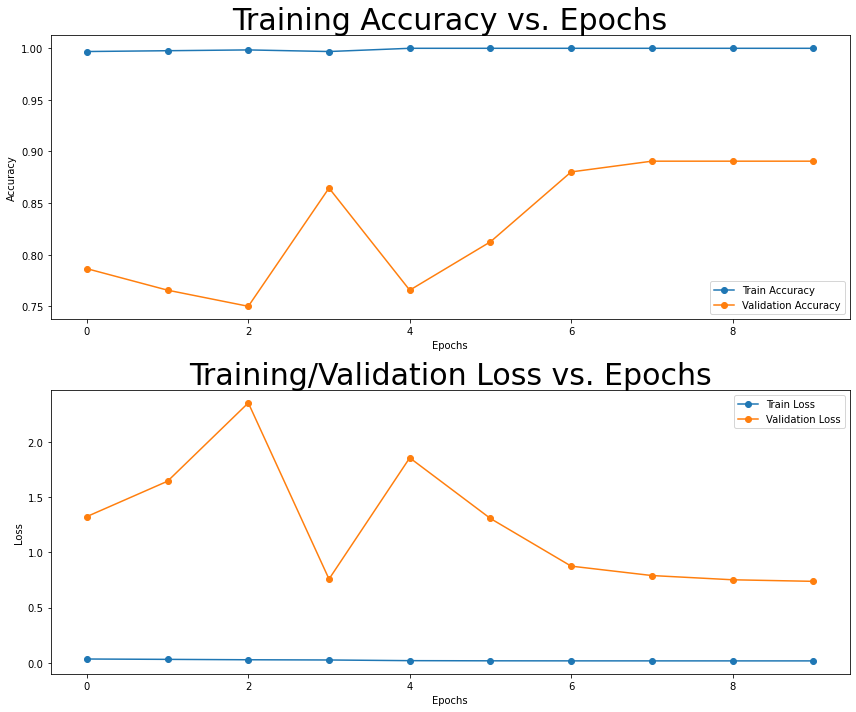

In [35]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs', fontsize=30)
ax[0].plot(accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs', fontsize=30)
ax[1].plot(loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Plotting the Actual & Predicted Labels of Images

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a Batch
    
    predictions = model.predict(img_array)
    
    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 92ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 95ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 96ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 94ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 93ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 78ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 93ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

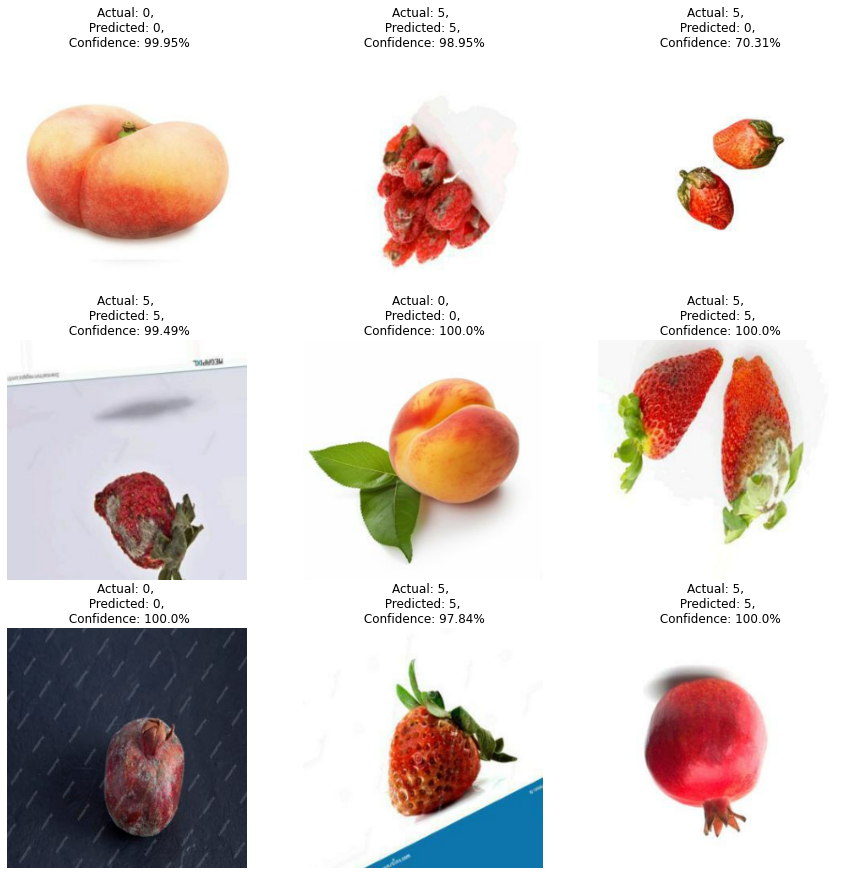

In [40]:
plt.figure(figsize=(15,15))
for images, labels in val_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3 ,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = labels[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis('off')

In [44]:
import os

model_version = max([int(i) for i in os.listdir("models") + [0]]) + 1 
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/1\assets


INFO:tensorflow:Assets written to: models/1\assets
